<a href="https://colab.research.google.com/github/Ibilis37/my_task/blob/master/my_task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

####Выведем информацию о имеющемся GPU

In [1]:
!nvidia-smi

Sun Apr 21 19:28:00 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

#### Импортируем  ultralytics и  YOLOv8

In [ ]:
!pip install ultralytics

In [ ]:
from ultralytics import YOLO
import os
from IPython.display import display, Image
from IPython import display
display.clear_output()
!yolo mode=checks

#### Импортируем данные из среды Roboflow

In [ ]:
!pip install roboflow
from roboflow import Roboflow
rf = Roboflow(api_key="tBrkHPcEPMjiouAJW96x")
project = rf.workspace("diana-komoltsewa").project("task_1-1shuo")
version = project.version(2)
dataset = version.download("yolov8")

###Для дальнейшей работы меняем пути к папкам в 'data.yaml'

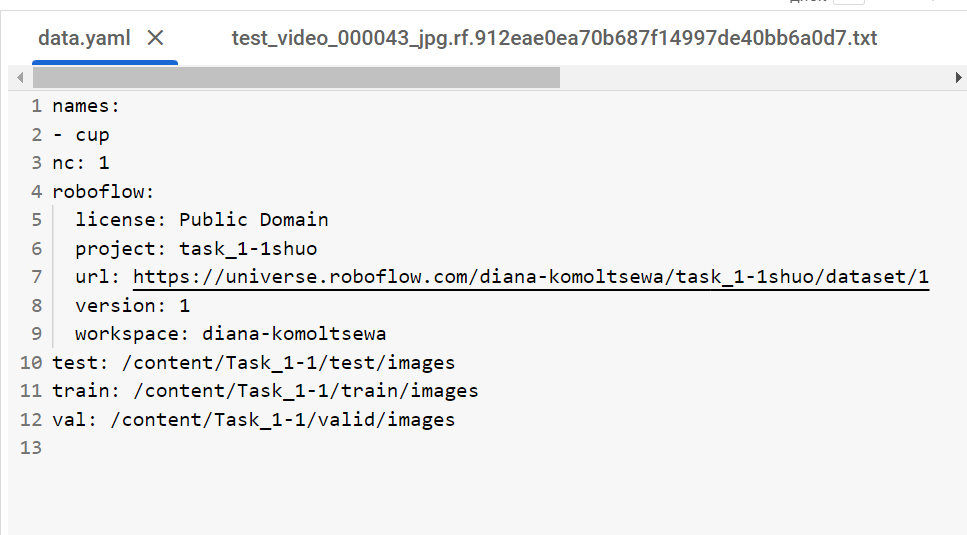![image.png]()


### Обучим модель yolov8m.pt на наших данных

In [ ]:
!yolo task=detect mode=train model=yolov8m.pt data={dataset.location}/data.yaml epochs=20 imgsz=640

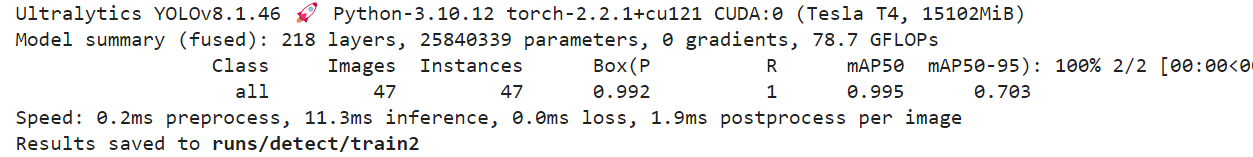

> * Class: Это класс объектов, которые обнаруживает модель.
* Images: Общее количество изображений в наборе данных.
* Instances: Общее количество экземпляров объектов на всех изображениях.
* Box(P): Precision (точность) модели, вычисленная для областей объектов.
* R: Recall (полнота) модели, оцененная для объектов.
* mAP50: Средняя точность (mean Average Precision) для обнаружения объектов при пороге IoU 0.5 (Intersection over Union).
* mAP50-95: Средняя точность для обнаружения объектов при IoU от 0.5 до 0.95.

Каждый из этих параметров представляет собой метрику оценки производительности модели по обнаружению объектов на изображениях во время процесса обучения. Например, высокие значения точности (Precision) и полноты (Recall) указывают на то, что модель успешно обнаруживает объекты на изображениях с высокой точностью и полнотой. Средняя точность (mAP) также важна, поскольку она дает общую оценку производительности модели на всем наборе данных.

#### Выведем графики для наглядной оценки качества работы модели

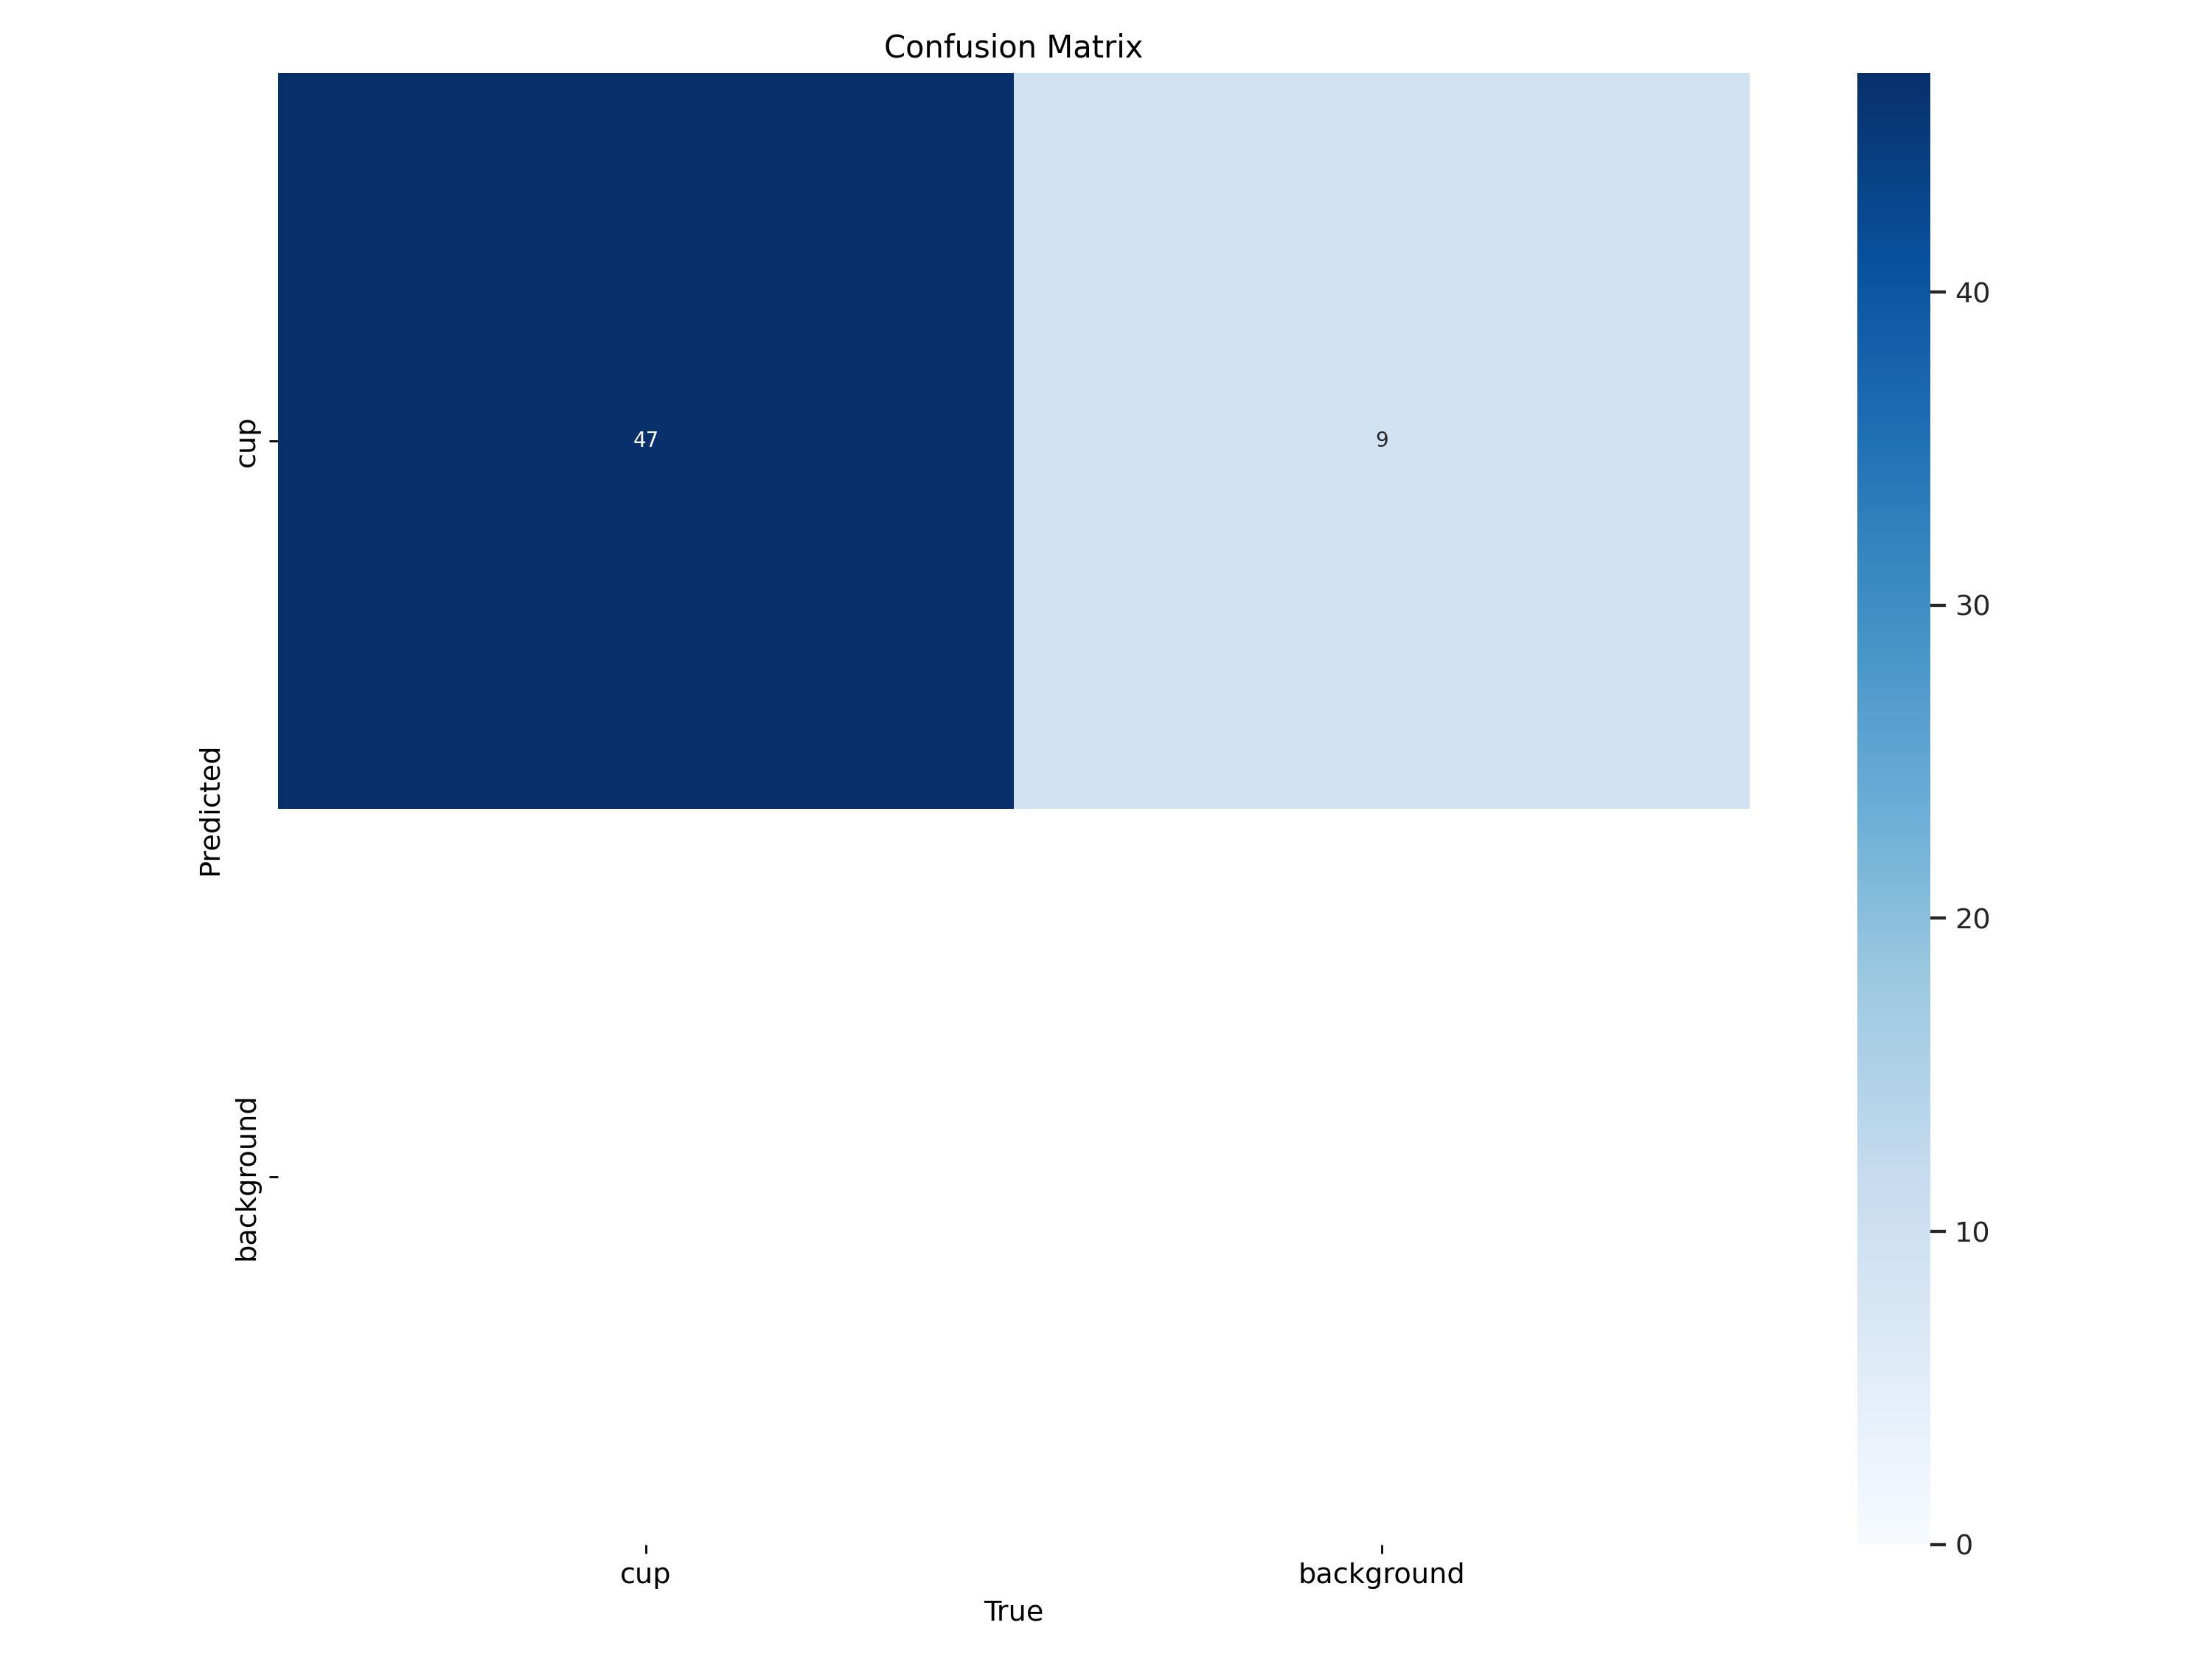

In [7]:
Image(filename=f'/content/runs/detect/train2/confusion_matrix.png', width=600)

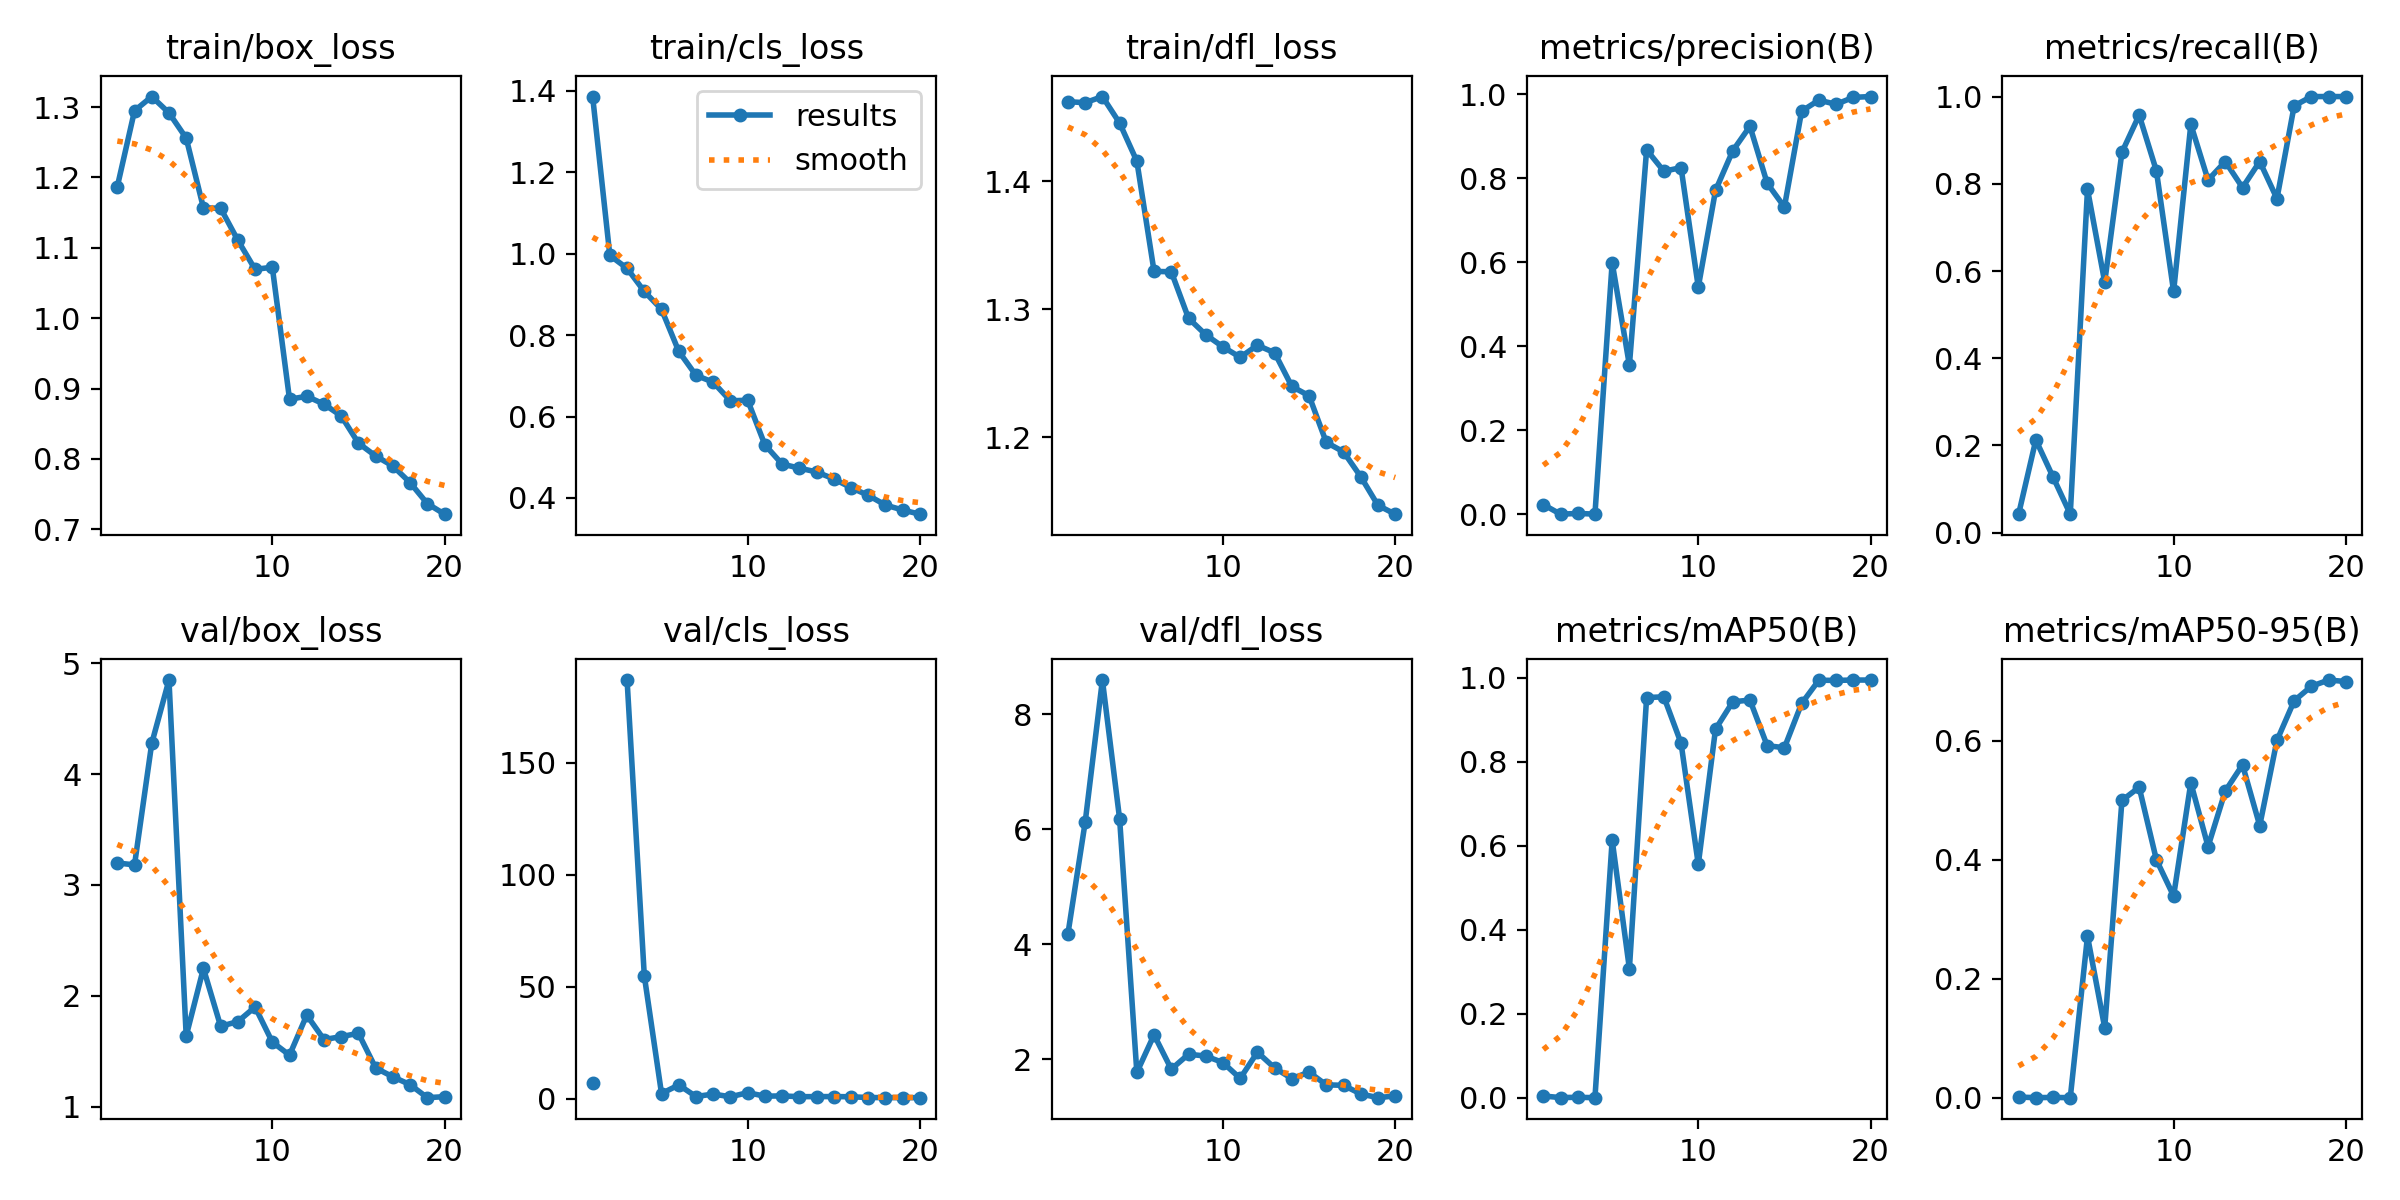

In [8]:
Image(filename=f'/content/runs/detect/train2/results.png', width = 600)

In [9]:
!yolo task=detect mode=val model=/content/runs/detect/train2/weights/best.pt conf=0.5 data={dataset.location}/data.yaml

Ultralytics YOLOv8.2.2 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 218 layers, 25840339 parameters, 0 gradients, 78.7 GFLOPs
val: Scanning /content/Task_1-2/valid/labels.cache... 47 images, 0 backgrounds, 0 corrupt: 100% 47/47 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 3/3 [00:05<00:00,  1.87s/it]
                   all         47         47      0.993          1      0.995      0.729
Speed: 0.2ms preprocess, 36.2ms inference, 0.0ms loss, 49.5ms postprocess per image
Results saved to runs/detect/val
💡 Learn more at https://docs.ultralytics.com/modes/val


#### Загрузим модель с лучшими показателями и протестируем на фото


In [ ]:
!yolo task=detect mode=predict model=/content/runs/detect/train2/weights/best.pt conf=0.5 source={dataset.location}/test/images

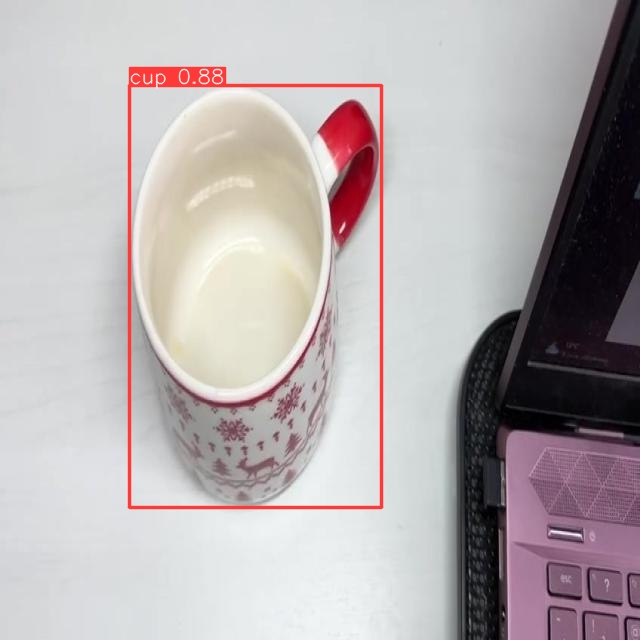

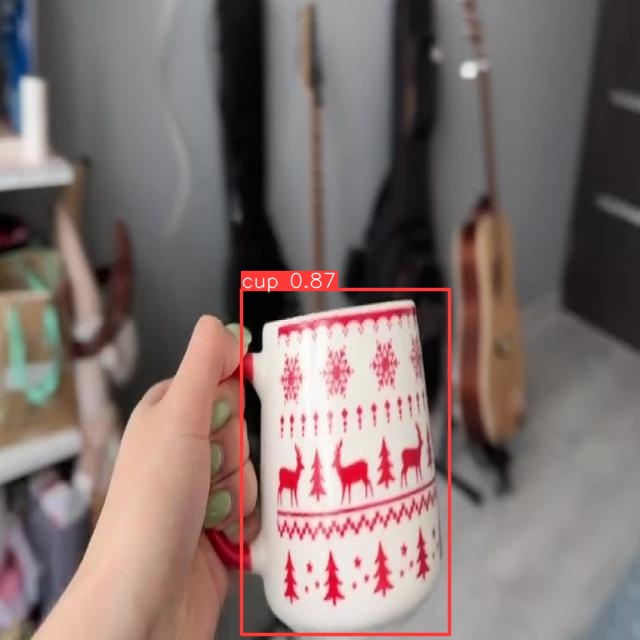

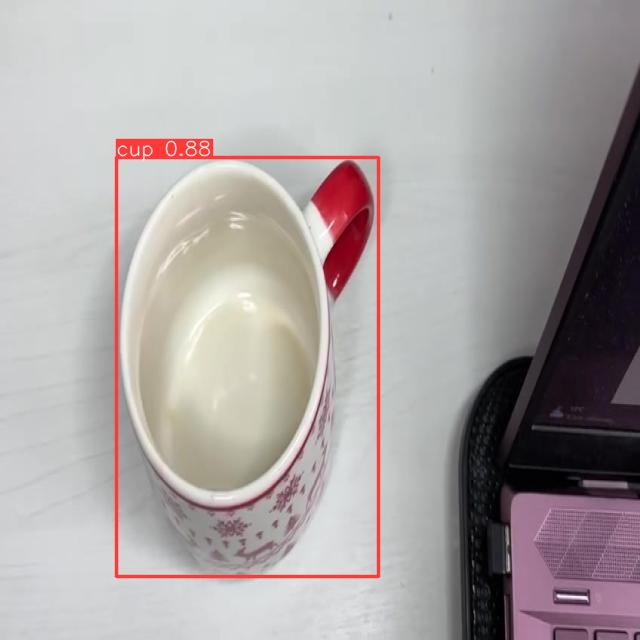

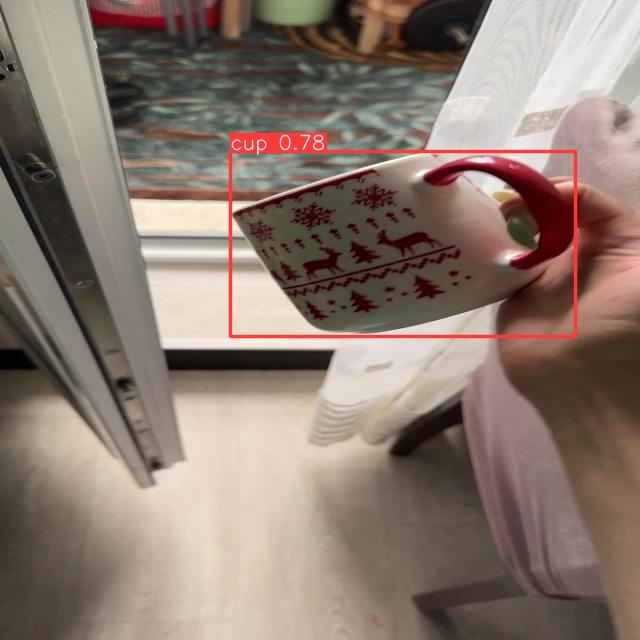

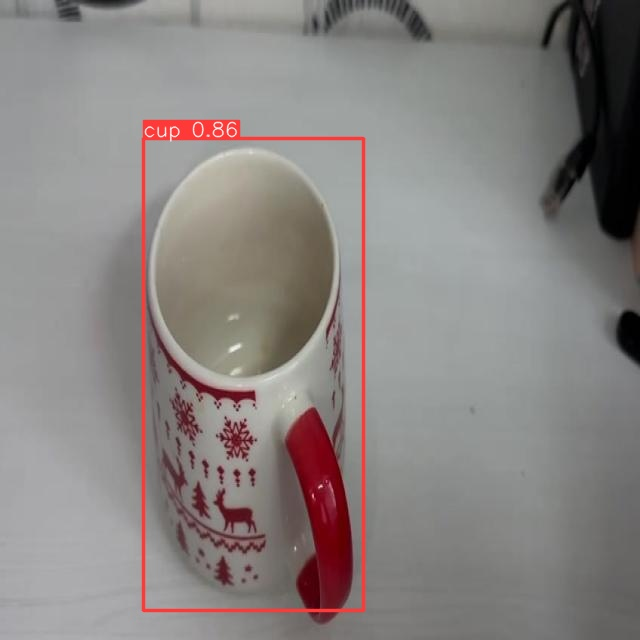

In [18]:
import glob
from IPython.display import Image, display
count = 0
for image_path in glob.glob(f'/content/runs/detect/predict/*.jpg'):
  count +=1
  display(Image(filename=image_path, height = 300))
  print('\n')
  if count >= 5:
    break

#### Выгружаем обученную модель в формате torchscript

In [12]:
import torch
from ultralytics import YOLO
model = YOLO('/content/runs/detect/train2/weights/best.pt')
model.export(format='torchscript')

Ultralytics YOLOv8.2.2 🚀 Python-3.10.12 torch-2.2.1+cu121 CPU (Intel Xeon 2.00GHz)
Model summary (fused): 218 layers, 25840339 parameters, 0 gradients, 78.7 GFLOPs

PyTorch: starting from '/content/runs/detect/train2/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 5, 8400) (49.6 MB)

TorchScript: starting export with torch 2.2.1+cu121...
TorchScript: export success ✅ 7.1s, saved as '/content/runs/detect/train2/weights/best.torchscript' (99.1 MB)

Export complete (13.3s)
Results saved to /content/runs/detect/train2/weights
Predict:         yolo predict task=detect model=/content/runs/detect/train2/weights/best.torchscript imgsz=640  
Validate:        yolo val task=detect model=/content/runs/detect/train2/weights/best.torchscript imgsz=640 data=/content/Task_1-2/data.yaml  
Visualize:       https://netron.app


'/content/runs/detect/train2/weights/best.torchscript'